In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import paysage

from paysage import batch

from paysage import preprocess as pre
from paysage import backends as be 

from paysage.layers import BernoulliLayer, GaussianLayer
from paysage.models.dbm import BoltzmannMachine

from paysage import optimizers
from paysage import schedules

from paysage import fit
from paysage import samplers

from paysage import penalties as pen

Running paysage with the python backend on the cpu


Obtaining the MNIST dataset

In [2]:
#from paysage import batch

mnist_path = "/Users/jai/mnist.h5"
mnist_shuffled_path = "/Users/jai/mnist_shuffled.h5"

batch.DataShuffler(mnist_path, mnist_shuffled_path, complevel=0).shuffle()

Visualizing the MNIST dataset

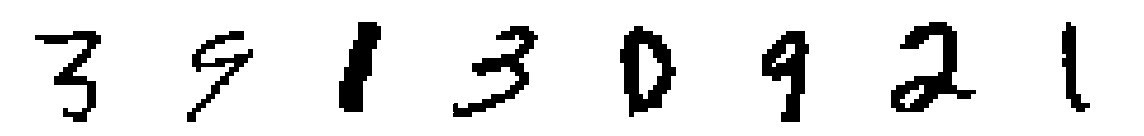

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
import seaborn as sns

# make sure the plots are shown in the notebook

def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r, row_titles=None):
    array = be.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(np.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=36)
            
    plt.tight_layout()
    plt.show(f)
    plt.close(f)
    

image_shape = (28, 28) # 28x28 = 784 pixels in every image
num_to_plot = 8 # of data points to plot

examples = data.get(mode='train') # shape (batch_size, 784)

example_plot = plot_image_grid(np.expand_dims(examples[:num_to_plot], 0), 
                               image_shape, vmin=0, vmax=1)

Data Preprocessing

In [3]:
from paysage import batch

from paysage import preprocess as pre
from paysage import backends as be 

batch_size = 100
transform = pre.Transformation(pre.binarize_color)

samples = be.float_tensor(pd.read_hdf(mnist_shuffled_path, key='train/images').values)
data = batch.batch.in_memory_batch(samples, batch_size, train_fraction=0.95, transform=transform)

data.reset_generator(mode='train')

Making a Hopfield Model

In [4]:
from paysage.layers import BernoulliLayer, GaussianLayer
from paysage.models.dbm import BoltzmannMachine

from paysage import optimizers
from paysage import schedules

num_hidden_units = 200

visible_layer = BernoulliLayer(data.ncols)
hidden_layer = GaussianLayer(num_hidden_units)
hopfield_net = BoltzmannMachine([visible_layer, hidden_layer])

hopfield_net.layers[1].set_fixed_params(['loc', 'log_var'])

def ADAM_optimizer(initial, coefficient):
    learning_rate = schedules.PowerLawDecay(initial=initial, coefficient=coefficient)
    return optimizers.ADAM(stepsize=learning_rate)

Training the model

In [5]:
from paysage import fit
from paysage import samplers

num_epochs = 20
monte_carlo_steps = 1

def train_model(model, num_epochs, monte_carlo_steps):
    model.initialize(data, method='glorot_normal')
    opt = ADAM_optimizer(1e-2, 1.0)
    trainer = fit.SGD(model, data)
    trainer.train(opt, num_epochs, method=fit.pcd, mcsteps=monte_carlo_steps)
    
train_model(model=hopfield_net, num_epochs=20, monte_carlo_steps=1)

Before training:
-ReconstructionError: 1.202162
-EnergyCoefficient: 0.131160
-HeatCapacity: 0.400626
-WeightSparsity: 0.335845
-WeightSquare: 1.592684
-KLDivergence: 0.187739
-ReverseKLDivergence: -0.038536

End of epoch 1: 
Time elapsed 9.004s
-ReconstructionError: 0.784482
-EnergyCoefficient: 0.219315
-HeatCapacity: 19.377713
-WeightSparsity: 0.280250
-WeightSquare: 2.485418
-KLDivergence: 0.075648
-ReverseKLDivergence: 0.124797

End of epoch 2: 
Time elapsed 8.964s
-ReconstructionError: 0.739758
-EnergyCoefficient: 0.288946
-HeatCapacity: 17.984580
-WeightSparsity: 0.277048
-WeightSquare: 2.730724
-KLDivergence: 0.097457
-ReverseKLDivergence: 0.202977

End of epoch 3: 
Time elapsed 8.431s
-ReconstructionError: 0.754478
-EnergyCoefficient: 0.362864
-HeatCapacity: 20.701052
-WeightSparsity: 0.274217
-WeightSquare: 2.868368
-KLDivergence: 0.109703
-ReverseKLDivergence: 0.293544

End of epoch 4: 
Time elapsed 8.33s
-ReconstructionError: 0.739098
-EnergyCoefficient: 0.357808
-HeatCapacit

Bernoulli RBM

In [8]:
visible_layer = BernoulliLayer(data.ncols)
hidden_layer = BernoulliLayer(num_hidden_units)
rbm = BoltzmannMachine([visible_layer, hidden_layer])

train_model(rbm, num_epochs, monte_carlo_steps)

Before training:
-ReconstructionError: 1.222717
-EnergyCoefficient: 0.129743
-HeatCapacity: 0.305224
-WeightSparsity: 0.337594
-WeightSquare: 1.596090
-KLDivergence: 0.171844
-ReverseKLDivergence: -0.034409

End of epoch 1: 
Time elapsed 7.725s
-ReconstructionError: 0.879299
-EnergyCoefficient: 0.286247
-HeatCapacity: 0.728868
-WeightSparsity: 0.217182
-WeightSquare: 25.438447
-KLDivergence: 0.084637
-ReverseKLDivergence: 0.196879

End of epoch 2: 
Time elapsed 6.494s
-ReconstructionError: 0.811006
-EnergyCoefficient: 0.256962
-HeatCapacity: 5.038619
-WeightSparsity: 0.213368
-WeightSquare: 45.021011
-KLDivergence: 0.030362
-ReverseKLDivergence: 0.222423

End of epoch 3: 
Time elapsed 6.546s
-ReconstructionError: 0.764565
-EnergyCoefficient: 0.255626
-HeatCapacity: 1.466987
-WeightSparsity: 0.215623
-WeightSquare: 65.682798
-KLDivergence: 0.045079
-ReverseKLDivergence: 0.167740

End of epoch 4: 
Time elapsed 6.324s
-ReconstructionError: 0.747053
-EnergyCoefficient: 0.304202
-HeatCapaci

Bernoulli RBM with L1 regularization

In [12]:
visible_layer = BernoulliLayer(data.ncols)
hidden_layer = BernoulliLayer(num_hidden_units)
rbm_L1 = BoltzmannMachine([visible_layer, hidden_layer])

rbm_L1.connections[0].weights.add_penalty({'matrix': pen.l1_penalty(1e-3)})

train_model(rbm_L1,num_epochs,monte_carlo_steps)

Before training:
-ReconstructionError: 1.220518
-EnergyCoefficient: 0.132275
-HeatCapacity: 0.313700
-WeightSparsity: 0.336518
-WeightSquare: 1.596825
-KLDivergence: 0.170219
-ReverseKLDivergence: -0.030361

End of epoch 1: 
Time elapsed 6.91s
-ReconstructionError: 0.910292
-EnergyCoefficient: 0.292759
-HeatCapacity: 0.451835
-WeightSparsity: 0.123155
-WeightSquare: 16.154426
-KLDivergence: 0.127708
-ReverseKLDivergence: 0.139695

End of epoch 2: 
Time elapsed 7.597s
-ReconstructionError: 0.820289
-EnergyCoefficient: 0.245473
-HeatCapacity: 1.040177
-WeightSparsity: 0.111725
-WeightSquare: 27.927070
-KLDivergence: 0.078706
-ReverseKLDivergence: 0.153426

End of epoch 3: 
Time elapsed 8.13s
-ReconstructionError: 0.790193
-EnergyCoefficient: 0.280253
-HeatCapacity: 0.908573
-WeightSparsity: 0.100998
-WeightSquare: 38.801772
-KLDivergence: 0.111625
-ReverseKLDivergence: 0.182700

End of epoch 4: 
Time elapsed 8.021s
-ReconstructionError: 0.757843
-EnergyCoefficient: 0.268019
-HeatCapacity

Deep-Boltzmann Machine with L1 penalty for each Layer

In [16]:
dbm = BoltzmannMachine([BernoulliLayer(data.ncols), # visible layer
                        BernoulliLayer(num_hidden_units), # hidden layer 1
                        BernoulliLayer(num_hidden_units) # hidden layer 2
                       ])


for conn in dbm.connections:
    conn.weights.add_penalty({'matrix':pen.l1_penalty(1e-3)})
    

def train_deep_model(model,num_epochs,monte_carlo_steps):
    model.initialize(data,method='glorot_normal')
    opt=ADAM_optimizer(1E-2,1.0)
    pretrainer=fit.LayerwisePretrain(model,data)
    pretrainer.train(opt, num_epochs, method=fit.pcd, mcsteps=monte_carlo_steps, init_method="glorot_normal")
    opt=ADAM_optimizer(1E-3,1.0)
    trainer=fit.SGD(model,data)
    trainer.train(opt,num_epochs,method=fit.pcd,mcsteps=monte_carlo_steps)

train_deep_model(dbm,num_epochs,monte_carlo_steps)

training model 0

Before training:
-ReconstructionError: 1.222694
-EnergyCoefficient: 0.130714
-HeatCapacity: 0.304890
-WeightSparsity: 0.337847
-WeightSquare: 1.601009
-KLDivergence: 0.169465
-ReverseKLDivergence: -0.033106

End of epoch 1: 
Time elapsed 7.724s
-ReconstructionError: 0.915362
-EnergyCoefficient: 0.314407
-HeatCapacity: 0.445234
-WeightSparsity: 0.126332
-WeightSquare: 15.067373
-KLDivergence: 0.146970
-ReverseKLDivergence: 0.147878

End of epoch 2: 
Time elapsed 7.936s
-ReconstructionError: 0.823271
-EnergyCoefficient: 0.325324
-HeatCapacity: 1.250134
-WeightSparsity: 0.117258
-WeightSquare: 26.597834
-KLDivergence: 0.120501
-ReverseKLDivergence: 0.227199

End of epoch 3: 
Time elapsed 7.866s
-ReconstructionError: 0.775740
-EnergyCoefficient: 0.291299
-HeatCapacity: 1.815104
-WeightSparsity: 0.107648
-WeightSquare: 38.074688
-KLDivergence: 0.086357
-ReverseKLDivergence: 0.204200

End of epoch 4: 
Time elapsed 7.249s
-ReconstructionError: 0.748892
-EnergyCoefficient: 0.

Reconstructions

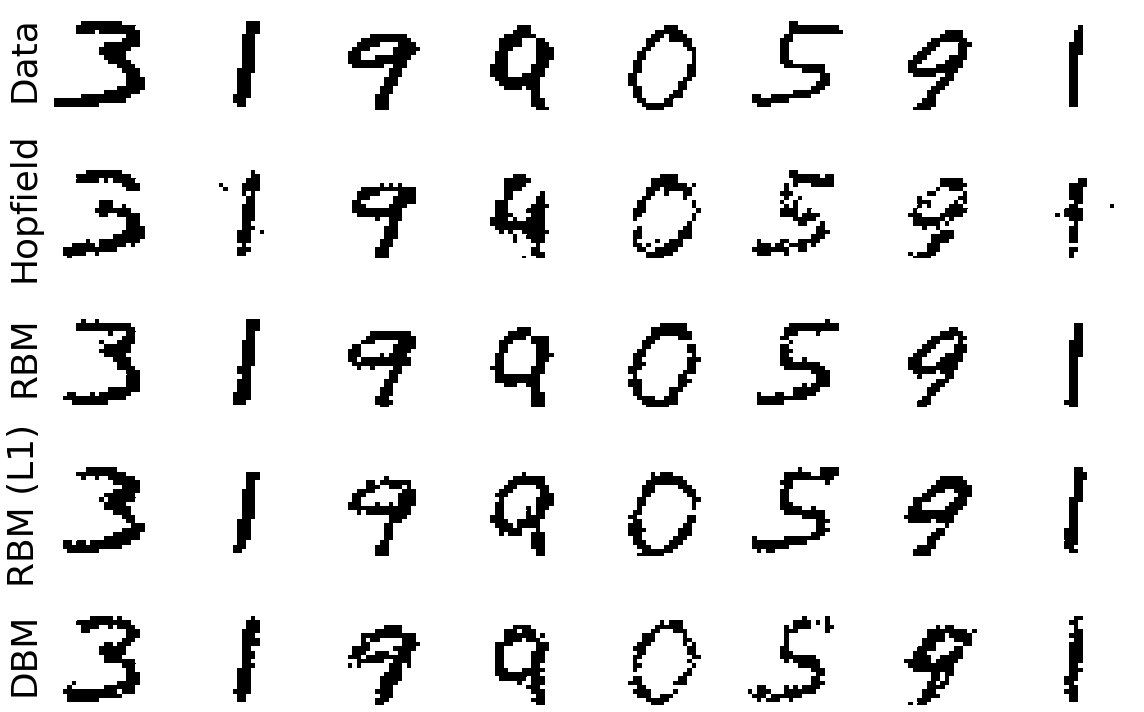

In [20]:
def compute_reconstructions(model, data):
    recons = model.compute_reconstructions(data).get_visible()
    return be.to_numpy_array(recons)

examples = data.get(mode='validate') 
data.reset_generator(mode='validate')

num_to_plot = 8

hopfield_reconstructions = compute_reconstructions(hopfield_net, examples[:num_to_plot])
rbm_reconstructions = compute_reconstructions(rbm, examples[:num_to_plot])
rbm_L1_reconstructions = compute_reconstructions(rbm_L1, examples[:num_to_plot])
dbm_reconstructions = compute_reconstructions(dbm, examples[:num_to_plot])

reconstruction_plot = plot_image_grid(
    np.array([examples[:num_to_plot], 
                 hopfield_reconstructions, 
                 rbm_reconstructions, 
                 rbm_L1_reconstructions,
                 dbm_reconstructions]), 
    image_shape, vmin=0, vmax=1, row_titles=["Data", "Hopfield", "RBM", "RBM (L1)", "DBM"])

Fantasy-Particles

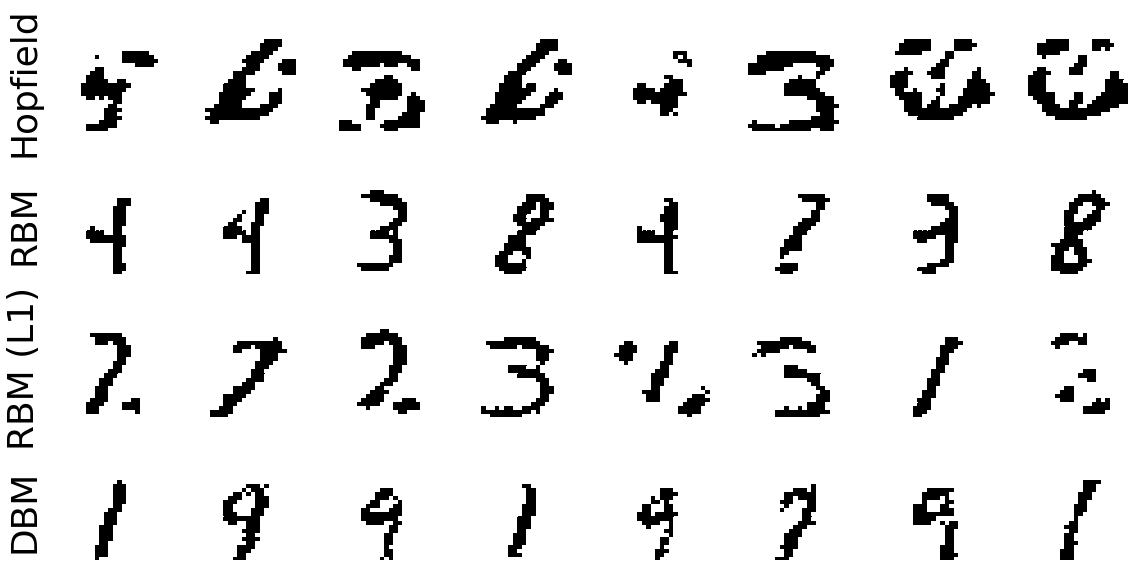

In [21]:
def compute_fantasy_particles(model,num_fantasy,num_steps,mean_field=True):
    """
    Draws samples from the model using Gibbs sampling Markov Chain Monte Carlo .
    Starts from randomly initialized points. 

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)
        num_steps (int): the number of update steps
        mean_field (bool; optional): run a final mean field step to compute probabilities

    Returns:
        tensor of shape (num_samples, num_visible_units)
    
    """
    schedule = schedules.Linear(initial=1.0, delta = 1 / (num_steps-1))
    fantasy = samplers.SequentialMC.generate_fantasy_state(model,
                                                           num_fantasy,
                                                           num_steps,
                                                           schedule=schedule,
                                                           beta_std=0.0,
                                                           beta_momentum=0.0)
    if mean_field:
        fantasy = model.mean_field_iteration(1, fantasy)
    fantasy_particles = fantasy.get_visible()        
    return be.to_numpy_array(fantasy_particles)

examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_fantasy = compute_fantasy_particles(hopfield_net, num_to_plot, 100, mean_field=False)
rbm_fantasy = compute_fantasy_particles(rbm, num_to_plot, 100, mean_field=False)
rbm_L1_fantasy = compute_fantasy_particles(rbm_L1, num_to_plot, 100, mean_field=False)
dbm_fantasy = compute_fantasy_particles(dbm, num_to_plot, 100, mean_field=False)

fantasy_plot = plot_image_grid(
    np.array([hopfield_fantasy, 
                 rbm_fantasy, 
                 rbm_L1_fantasy,
                 dbm_fantasy]), 
    image_shape, vmin=0, vmax=1, row_titles=["Hopfield", "RBM", "RBM (L1)", "DBM"])

Denoising the images

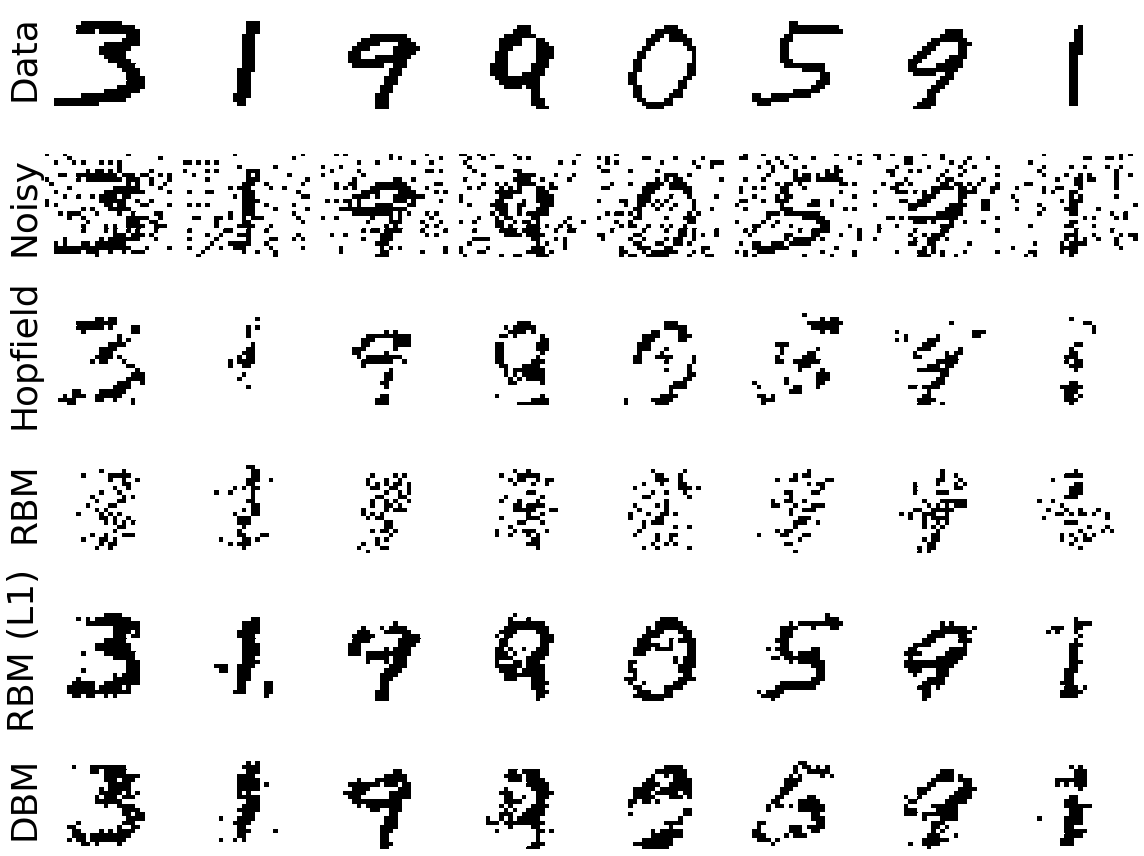

In [23]:
##### denoise MNIST images
# get validation data
examples = data.get(mode='validate') # shape (batch_size, 784)
# reset data generator to beginning of the validation set
data.reset_generator(mode='validate') 

# add some noise to the examples by randomly flipping some pixels 0 -> 1 and 1 -> 0
fraction_to_flip=0.15
# create flipping mask
flip_mask=be.rand_like(examples) < fraction_to_flip
# compute noisy data
noisy_data=(1-flip_mask) * examples + flip_mask * (1 - examples)

# define number of digits to display
num_to_display=8
# compute de-noised images
hopfield_denoised=compute_reconstructions(hopfield_net,noisy_data[:num_to_display])
rbm_denoised=compute_reconstructions(rbm,noisy_data[:num_to_display])
rbm_L1_denoised=compute_reconstructions(rbm_L1,noisy_data[:num_to_display])
dbm_denoised=compute_reconstructions(dbm,noisy_data[:num_to_display])

denoising_plot = plot_image_grid(
    np.array([examples[:num_to_plot], 
                 noisy_data[:num_to_plot], 
                 hopfield_denoised, 
                 rbm_denoised, 
                 rbm_L1_denoised,
                 dbm_denoised]), 
    image_shape, vmin=0, vmax=1, row_titles=["Data", "Noisy", "Hopfield", "RBM", "RBM (L1)", "DBM"])

Weights-Visualization

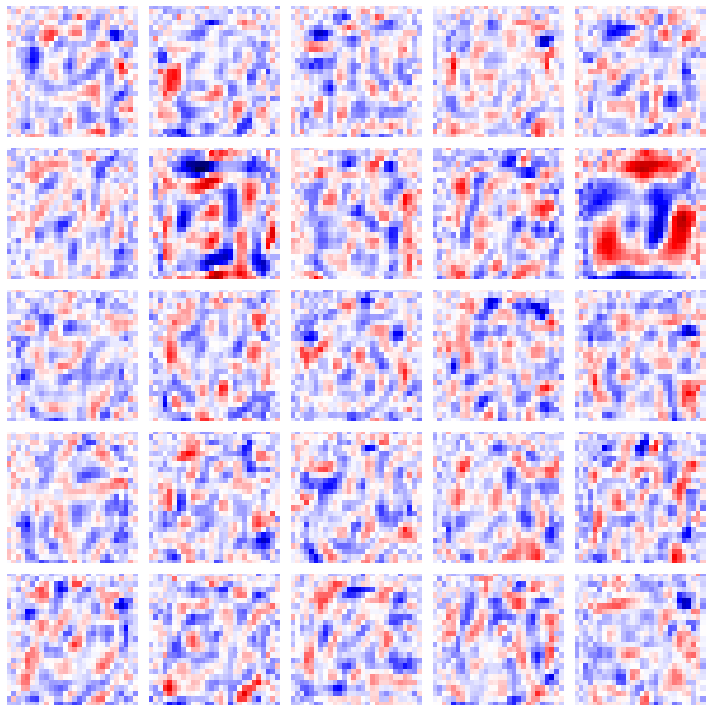

In [25]:
#plot the weights of the hopfield model
hopfield_weights = plot_image_grid(
    be.reshape(hopfield_net.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(hopfield_net.connections[0].weights.W()), 
    vmax=be.tmax(hopfield_net.connections[0].weights.W()),
    cmap=cm.seismic)

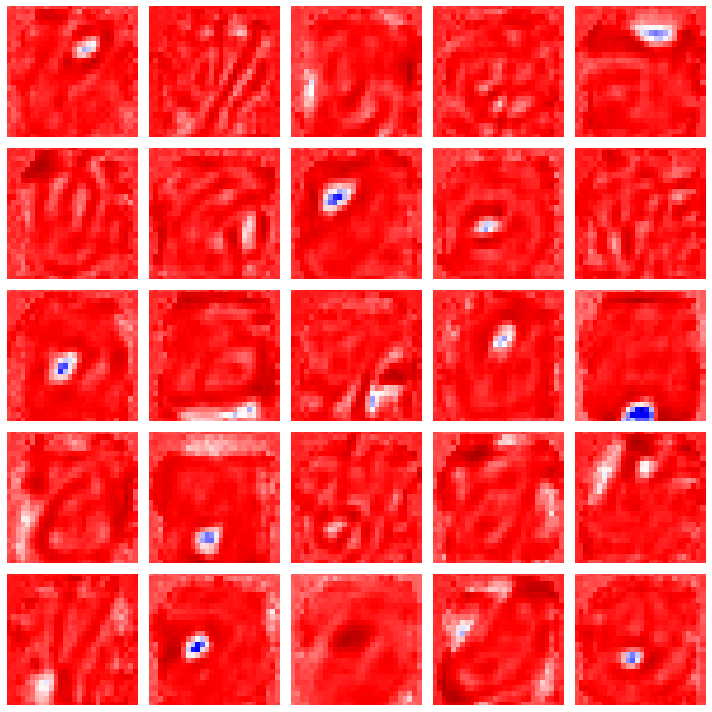

In [26]:
# plot the weights of the RBM
rbm_weights = plot_image_grid(
    be.reshape(rbm.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(rbm.connections[0].weights.W()), 
    vmax=be.tmax(rbm.connections[0].weights.W()),
    cmap=cm.seismic)

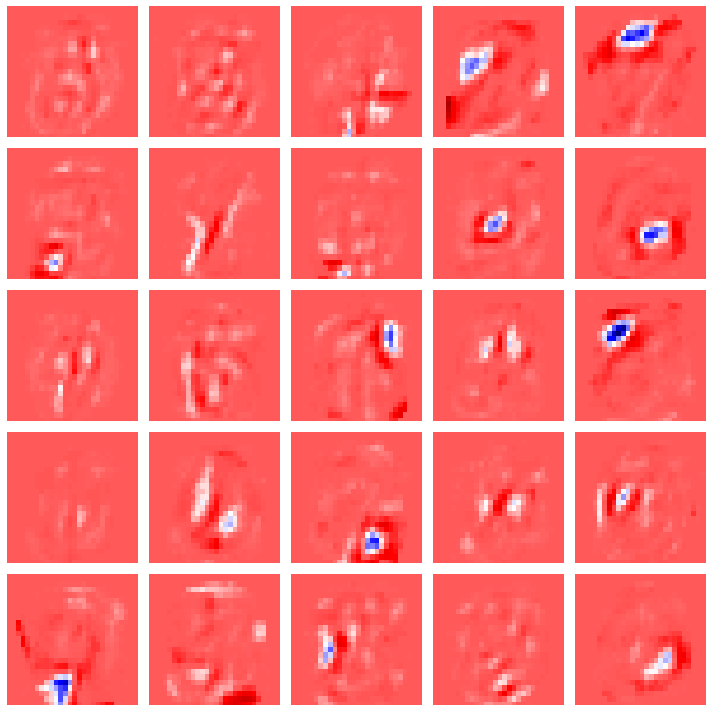

In [27]:
# plot the weights of the L1 regularized RBM
rbmL1_weights = plot_image_grid(
    be.reshape(rbm_L1.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(rbm_L1.connections[0].weights.W()), 
    vmax=be.tmax(rbm_L1.connections[0].weights.W()),
    cmap=cm.seismic)

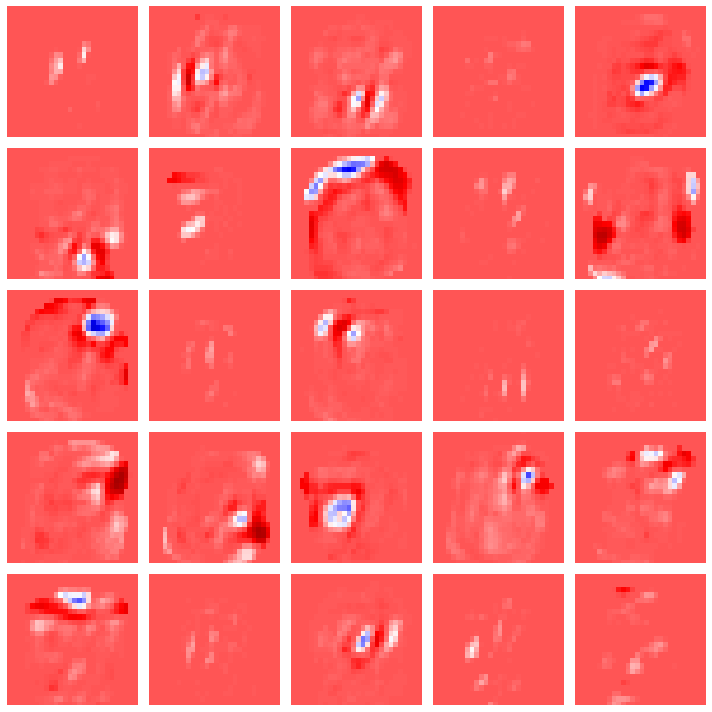

In [28]:
# plot the weights of the first layer of the dbm
dbm_weights = plot_image_grid(
    be.reshape(dbm.connections[0].weights.W(trans=True)[:25], (5,5,784)), 
    image_shape, 
    vmin=be.tmin(dbm.connections[0].weights.W()), 
    vmax=be.tmax(dbm.connections[0].weights.W()),
    cmap=cm.seismic)

In [29]:
data.close() # close the HDF5 store with the MNIST dataset